In [135]:
!pip install xgboost

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [136]:
%matplotlib inline
import csv
import pandas as pd
import numpy as np
import csv
import boto3
import datetime
import io
import s3fs
import matplotlib.pyplot as plt
import xgboost as xgb

In [ ]:
def pandas_to_s3(df, key):
    '''
    upload data to S3
    '''
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index=False, encoding='utf-8')
    
    OBJ_S3.Object(S_BUCKET,key).put(Body=csv_buffer.getvalue())
    
    LOGGER.info('object_name: ' + key)   
    return None

In [13]:
def read_data_from_s3(key):
    '''
    read od from S3
    '''
    client = boto3.client('s3')
    obj_op = client.get_object(Bucket='machin-learning-test', Key=key)
    df =pd.read_csv(obj_op['Body'])
    return df

# Part1 AWS-Machine Learning

#### Read data form S3

In [122]:
key='ex1_test/user_train.csv'
user_train=read_data_from_s3(key)
user_train.head()

,vehicle_id,data_count,driving_hour,use_day,total_mileage,ua_time,ud_time,driving_min,day_driving_time,driver_type
0,000CBF148864,32,0,1,4.983610e+03,0,0,0,0.00,less use driver
1,000CBF148865,21110,88,44,2.136582e+06,5,65,5280,120.00,mid time driver
2,000CBF14886E,203,1,5,2.553250e+04,0,8,60,12.00,less use driver
3,000CBF148874,49,0,2,3.679998e+03,0,0,0,0.00,less use driver
4,000CBF148887,10261,43,37,1.577319e+06,1800,1443,2580,69.73,mid time driver


In [105]:
key2='ex1_test/user_test.csv'
user_test=read_data_from_s3(key2)
user_test.head()

,vehicle_id,data_count,driving_hour,use_day,total_mileage,ua_time,ud_time,driving_min,day_driving_time,driver_type
0,000000000000,2,0,1,5.555560e-01,0,0,0,0.00,less use driver
1,000CBF148831,3562,15,18,2.897005e+05,0,6,900,50.00,short time driver
2,000CBF148844,11079,46,36,1.325116e+06,286,341,2760,76.67,mid time driver
3,000CBF148894,1142,5,5,9.435222e+04,14,17,300,60.00,short time driver
4,000CBF1488A2,1679,7,6,2.084492e+05,88,108,420,70.00,mid time driver


#### Read output from S3

In [19]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('machin-learning-test')
Prefix="ex1_test/output/batch-prediction/result"
name=[]
time=[] ##get s3 file name & create time
for obj in bucket.objects.filter(Prefix=Prefix):
    name.append(obj.key)
    time.append(obj.last_modified)
    bucket_info= pd.DataFrame(
    {'name': name,
     'time': time,}) 
np.set_printoptions(suppress=True)
fs = s3fs.S3FileSystem()
obj_list=[]
for obj in bucket_info['name']:
    obj_list.append(fs.open('s3://machin-learning-test/{}'.format(obj)))
df_list=[]  #open object and combine then             
for file in obj_list:
            df = pd.read_csv(file, compression='gzip')
            df_list.append(df)
            final_df = pd.concat(df_list)

In [89]:
final_df['trueLabel']=final_df['trueLabel']/1000
final_df['score']=final_df['score']/1000

In [92]:
final_df.head()

,tag,trueLabel,score
0,000000000000,0.000556,88.95799
1,000CBF148831,289.700546,275.57210
2,000CBF148844,1325.115564,960.49220
3,000CBF148894,94.352216,222.42080
4,000CBF1488A2,208.449164,509.29850


#### Plot actual & predict value

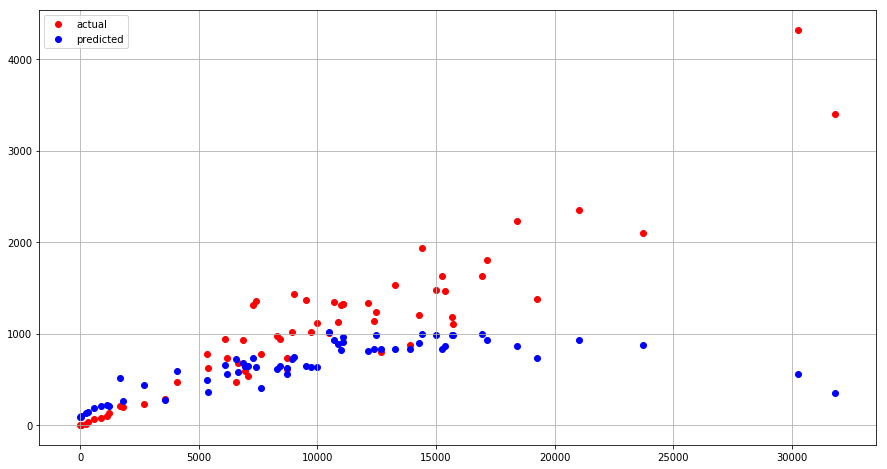

In [113]:
plt.figure(figsize=(15,8))
plt.scatter(x=user_test.data_count, y=final_df.trueLabel,color='r',label='actual',)
plt.scatter(x=user_test.data_count, y=final_df.score,color='b',label='predicted')
plt.grid(True)
plt.legend()

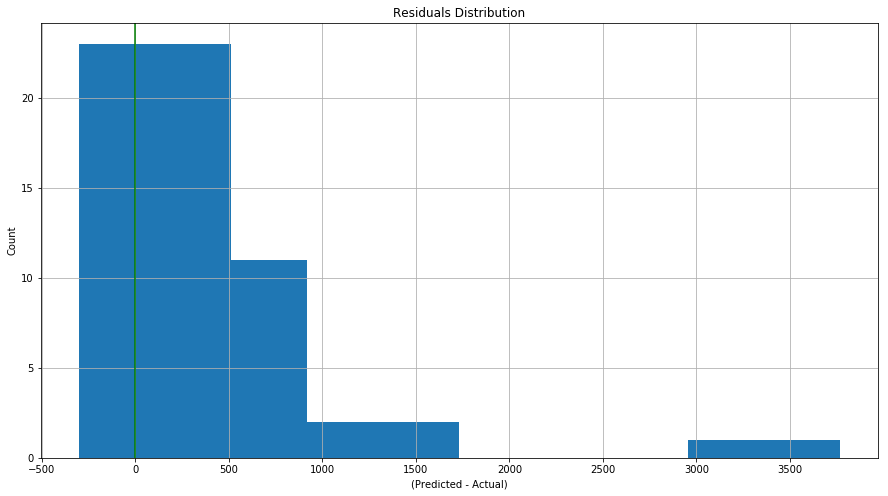

In [114]:
plt.figure(figsize=(15,8))
# Training Data Residuals
residuals = (final_df.trueLabel - final_df.score)

plt.hist(residuals)
plt.grid(True)
plt.xlabel('(Predicted - Actual)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='g')
# left of 0 = prediction < actual
# right of 0 = prediction > actual

#### Read output_custom_model from S3

In [115]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('machin-learning-test')
Prefix="ex1_test/output_custom_model/batch-prediction/result"
name=[]
time=[] ##get s3 file name & create time
for obj in bucket.objects.filter(Prefix=Prefix):
    name.append(obj.key)
    time.append(obj.last_modified)
    bucket_info= pd.DataFrame(
    {'name': name,
     'time': time,}) 
np.set_printoptions(suppress=True)
fs = s3fs.S3FileSystem()
obj_list=[]
for obj in bucket_info['name']:
    obj_list.append(fs.open('s3://machin-learning-test/{}'.format(obj)))
df_list=[]  #open object and combine then             
for file in obj_list:
            df = pd.read_csv(file, compression='gzip')
            df_list.append(df)
            final_df = pd.concat(df_list)

In [117]:
final_df['trueLabel']=final_df['trueLabel']/1000
final_df['score']=final_df['score']/1000

In [118]:
final_df.head()

,tag,trueLabel,score
0,000000000000,0.000556,-0.136891
1,000CBF148831,289.700546,233.953000
2,000CBF148844,1325.115564,773.791800
3,000CBF148894,94.352216,77.831850
4,000CBF1488A2,208.449164,126.431300


#### Plot actual & predict value

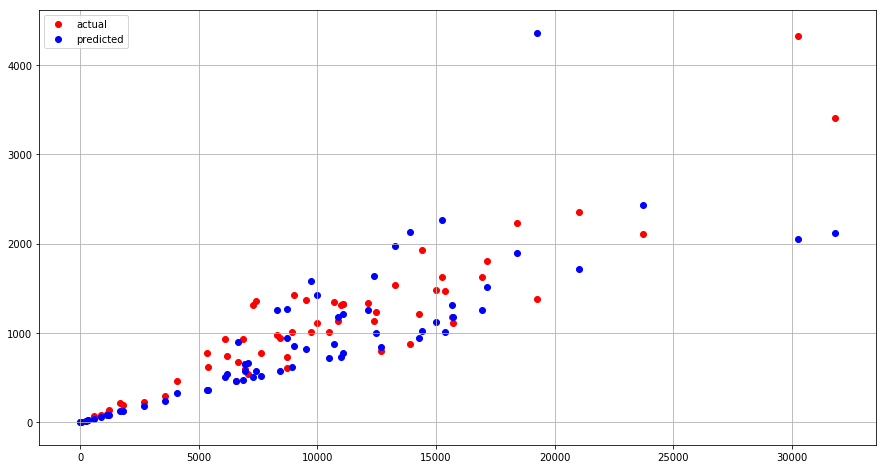

In [119]:
plt.figure(figsize=(15,8))
plt.scatter(x=user_test.data_count, y=final_df.trueLabel,color='r',label='actual',)
plt.scatter(x=user_test.data_count, y=final_df.score,color='b',label='predicted')
plt.grid(True)
plt.legend()

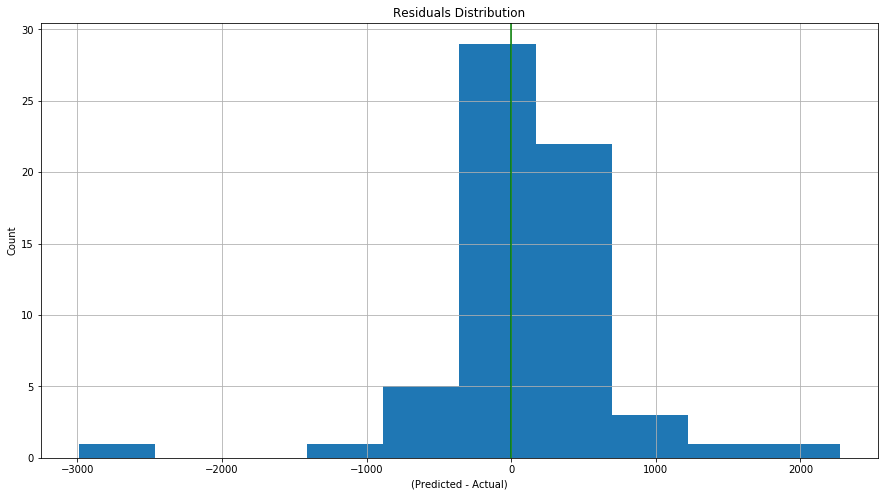

In [120]:
plt.figure(figsize=(15,8))
# Training Data Residuals
residuals = (final_df.trueLabel - final_df.score)

plt.hist(residuals)
plt.grid(True)
plt.xlabel('(Predicted - Actual)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='g')
# left of 0 = prediction < actual
# right of 0 = prediction > actual

#### Summary

1.AWS-ML使用上很方便 

2.AWS-ML訓練模型速度偏慢；200筆資料也要4分鐘

3.預測準確率並沒有很好

# Part2 使用XGboost

In [125]:
user_train['total_mileage']=user_train['total_mileage']/1000
user_test['total_mileage']=user_test['total_mileage']/1000

In [141]:
X_train = user_train.drop(['total_mileage','vehicle_id','driver_type'],axis=1)
y_train = user_train['total_mileage'].ravel() 

X_test = user_test.drop(['total_mileage','vehicle_id','driver_type'],axis=1)
y_test = user_test['total_mileage'].ravel() 

In [142]:
lm=xgb.XGBRegressor() ##初始化
lm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [143]:
lm.fit(X_train,y_train, eval_set = [(X_train, y_train), (X_test, y_test)])

[0]	validation_0-rmse:741.876	validation_1-rmse:1170.18
[1]	validation_0-rmse:679.648	validation_1-rmse:1060.27
[2]	validation_0-rmse:623.607	validation_1-rmse:960.134
[3]	validation_0-rmse:573.121	validation_1-rmse:873.227
[4]	validation_0-rmse:527.831	validation_1-rmse:794.283
[5]	validation_0-rmse:486.982	validation_1-rmse:724.969
[6]	validation_0-rmse:449.997	validation_1-rmse:659.677
[7]	validation_0-rmse:416.675	validation_1-rmse:601.548
[8]	validation_0-rmse:386.486	validation_1-rmse:550.645
[9]	validation_0-rmse:359.395	validation_1-rmse:505.593
[10]	validation_0-rmse:334.88	validation_1-rmse:466.188
[11]	validation_0-rmse:312.955	validation_1-rmse:431.773
[12]	validation_0-rmse:293.352	validation_1-rmse:402.507
[13]	validation_0-rmse:275.722	validation_1-rmse:377.362
[14]	validation_0-rmse:259.747	validation_1-rmse:355.012
[15]	validation_0-rmse:245.37	validation_1-rmse:337.867
[16]	validation_0-rmse:232.613	validation_1-rmse:323.799
[17]	validation_0-rmse:221.316	validation_1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [144]:
result=lm.evals_result() #rmse

In [146]:
training_rounds = range(len(result['validation_0']['rmse']))

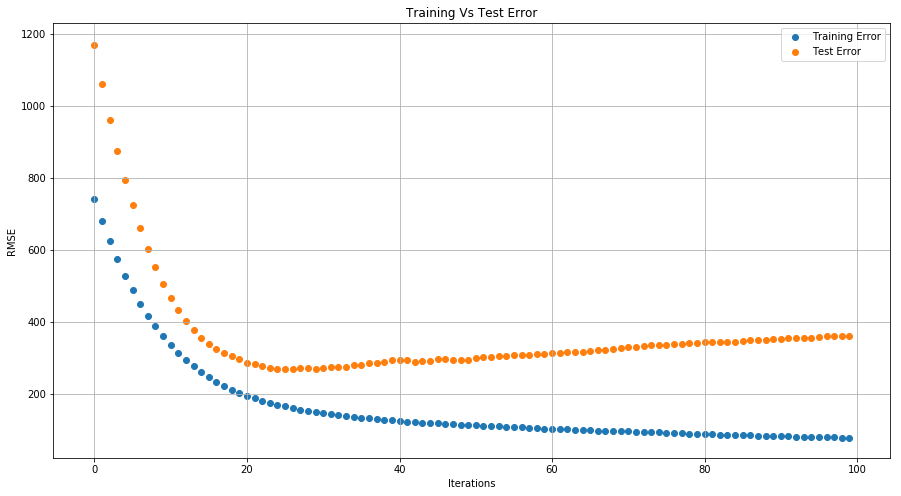

In [148]:
plt.figure(figsize=(15,8))
plt.scatter(x=training_rounds,y=result['validation_0']['rmse'],label='Training Error') #訓練資料的誤差
plt.scatter(x=training_rounds,y=result['validation_1']['rmse'],label='Test Error') #測試資料的誤差
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Test Error')
plt.legend()

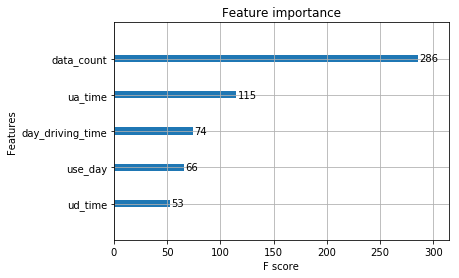

In [153]:
xgb.plot_importance(lm) #重要因子